# Coleta de dados

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# Classes do modelo
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
nltk.download('rslp')
nltk.download('stopwords')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\arm4\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arm4\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
dataset = pd.read_csv("datasets/reviews.csv")

# Pré-Processamento dos Dados

## Definindo Tipos

In [3]:
dataset.head(5)

,Unnamed: 0,order_id,review_id,review_score,review_comment_message
0,3,658677c97b385a9be170737859d3511b,e64fb393e7b32834bb789ff8bb30750e,1,Recebi bem antes do prazo estipulado.
1,4,8e6bfb81e283fa7e4f11123a3fb894f1,f7c4243c7fe1938f181bec41a392bdeb,1,Parabéns lojas lannister adorei comprar pela I...
2,9,b9bf720beb4ab3728760088589c62129,8670d52e15e00043ae7de4c01cc2fe06,0,aparelho eficiente. no site a marca do aparelh...
3,12,9d6f15f95d01e79bd1349cc208361f09,4b49719c8a200003f700d3d986ea1a19,0,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,15,e51478e7e277a83743b6f9991dbfa3fb,3948b09f7c818e2d86c9a546758b2335,1,"Vendedor confiável, produto ok e entrega antes..."


In [4]:

stopword = stopwords.words("portuguese")
stem = RSLPStemmer()
vectorizer = TfidfVectorizer()
def clear(review):
  review = review.lower()
  # remove pula de linha 
  review = re.sub('\n', ' ', review)        
  review = re.sub('\r', ' ', review)

  # remove numero 
  review = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', ' #numero ', review)

  # remove caracters especiais 
  review = re.sub(r'R\$', ' ', review)
  review = re.sub(r'\W', ' ', review)
  review = re.sub(r'\s+', ' ', review)

  # remove links 
  urls = re.findall('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', review)
  if len(urls) > 0:
      for url in urls:
          for link in url:
              review = review.replace(link, '')
      review = review.replace(':', '')
      review = review.replace('/', '')
  return review
reviews = dataset["review_comment_message"]
reviews = reviews.apply(lambda review: clear(review))
reviews = reviews.apply(lambda review: word_tokenize(review))
reviews = reviews.apply(lambda words_review: [word for word in words_review if word not in stopword])
reviews = reviews.apply(lambda words_review: [stem.stem(word) for word in words_review ])
reviews = reviews.apply(lambda words_review: " ".join(words_review))
reviews = vectorizer.fit_transform(reviews)
reviews


<40874x7920 sparse matrix of type '<class 'numpy.float64'>'
	with 277461 stored elements in Compressed Sparse Row format>

In [5]:
X = reviews.copy()
y = dataset["review_score"].copy()
y = np.array(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 199)


In [7]:
# vamos criar um classificador kNN:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

# e ver a sua performance no dataset de teste
print(classification_report(y_test, model_knn.predict(X_test)))


              precision    recall  f1-score   support

          -1       0.72      0.37      0.49      3208
           0       0.32      0.31      0.32      2918
           1       0.63      0.80      0.71      6137

    accuracy                           0.57     12263
   macro avg       0.56      0.49      0.50     12263
weighted avg       0.58      0.57      0.56     12263



# Plotagem das acurácias para o knn:

In [9]:
from sklearn import metrics

k_range=range(1,26)
scores=[]

for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

In [10]:
# Acurácia máxima:
max(scores)

0.5722906303514638

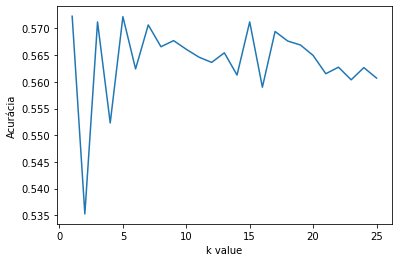

In [11]:
import matplotlib.pyplot as plt

plt.plot(k_range, scores)
plt.xlabel('k value')
plt.ylabel('Acurácia')

plt.show()

# Plotagem da métrica F1-score:

In [19]:
from sklearn import metrics

k_range=range(1,26)
scores=[]

for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)
    scores.append(metrics.f1_score(y_test, y_pred,average=None))

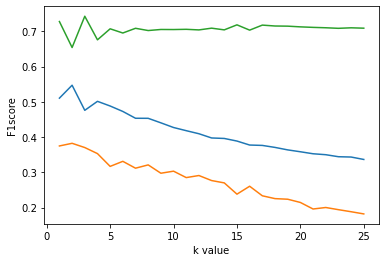

In [20]:
import matplotlib.pyplot as plt

plt.plot(k_range, scores)
plt.xlabel('k value')
plt.ylabel('F1score')

plt.show()

# Otimizando com o Grid search:


In [ ]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10,shuffle=True, random_state=1)

model = KNeighborsClassifier()
param_grid = {'n_neighbors':np.arange(1,26,2),
              'metric': ['euclidean', 'manhattan', 'minkowski']
              }


gs = GridSearchCV(model, param_grid, refit= False, cv=skf)

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             refit=False)

In [ ]:
# Hiperparâmetros otimizados:
print("Os melhores hiparametros:", gs.best_params_)

Os melhores hiparametros: {'metric': 'euclidean', 'n_neighbors': 5}


In [ ]:
# treinando o modelo com hiperparametros otimizados:
model_knn = KNeighborsClassifier(n_neighbors=5, metric= 'euclidean')
model_knn.fit(X_train, y_train)

# e ver a sua performance no dataset de teste
print(classification_report(y_test, model_knn.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.72      0.37      0.49      3208
           0       0.32      0.31      0.32      2918
           1       0.63      0.80      0.71      6137

    accuracy                           0.57     12263
   macro avg       0.56      0.49      0.50     12263
weighted avg       0.58      0.57      0.56     12263



# Otimizando com o Randon search:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


rand = RandomizedSearchCV(model, param_grid, cv=skf, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
                   estimator=KNeighborsClassifier(),
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
                   random_state=5, scoring='accuracy')

In [ ]:
# Hiperparâmetros otimizados:
print("Os melhores hiparametros:", rand.best_params_)

Os melhores hiparametros: {'n_neighbors': 7, 'metric': 'minkowski'}


In [ ]:
# treinando o modelo com hiperparametros otimizados:
model_knn_1 = KNeighborsClassifier(n_neighbors=7, metric= 'minkowski')
model_knn_1.fit(X_train, y_train)

# e ver a sua performance no dataset de teste
print(classification_report(y_test, model_knn_1.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.74      0.33      0.45      3208
           0       0.33      0.30      0.31      2918
           1       0.62      0.83      0.71      6137

    accuracy                           0.57     12263
   macro avg       0.56      0.48      0.49     12263
weighted avg       0.58      0.57      0.55     12263

